In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from glob import glob
import tensorflow as tf
import tensorflow.keras as keras
import keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, Dense, Reshape, Flatten, Softmax, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load dataset

#### Custom Dataloader

In [2]:
def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   # shape: (size,size,3) -> (size,size,1)
    image = image/255.   # normalize
    return image

def load_data(root_path, size):
    images = []
    masks = []
    
    x = 0   # additional variable to identify images consisting of 2 or more masks
    
    for path in sorted(glob(root_path)):
        img = load_image(path, size)   # read mask or image
            
        if 'mask' in path:
            if x:   # this image has masks more than one
                masks[-1] += img   # add the mask to the last mask
                    
                # When 2 masks are added, the range can increase by 0-2. So we will reduce it again to the range 0-1.
                masks[-1] = np.array(masks[-1]>0.5, dtype='float64')
            else:
                masks.append(img)
                x = 1   # if the image has a mask again, the above code will run next time
        else:
            images.append(img)
            x = 0   # for moving to the next image
    return np.array(images), np.array(masks)

In [3]:
size = 128   # image size: 128x128
root_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/*/*'
X, y = load_data(root_path, size)

In [4]:
# drop normal class because normal class has not mask
X = X[:647]
y = y[:647]

print(f"X shape: {X.shape}     |  y shape: {y.shape}")

# prepare data to modeling
X = np.expand_dims(X, -1)
y = np.expand_dims(y, -1)

print(f"\nX shape: {X.shape}  |  y shape: {y.shape}")

X shape: (647, 128, 128)     |  y shape: (647, 128, 128)

X shape: (647, 128, 128, 1)  |  y shape: (647, 128, 128, 1)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_val shape:',X_val.shape)
print('y_val shape:',y_val.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

X_train shape: (465, 128, 128, 1)
y_train shape: (465, 128, 128, 1)
X_val shape: (117, 128, 128, 1)
y_val shape: (117, 128, 128, 1)
X_test shape: (65, 128, 128, 1)
y_test shape: (65, 128, 128, 1)


#### Visualization of training images

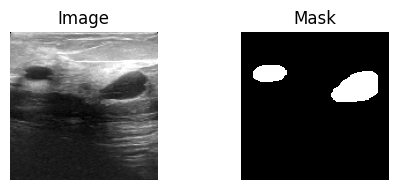

In [6]:
image = X_train[31]
mask = y_train[31]

fig, axes = plt.subplots(1, 2, figsize=(5, 2))
axes[0].imshow(image, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Image')

axes[1].imshow(mask*255, cmap='gray', vmin=0, vmax=1)
axes[1].axis('off')
axes[1].set_title('Mask')

plt.tight_layout()
plt.show()

#### Visualization of validation images

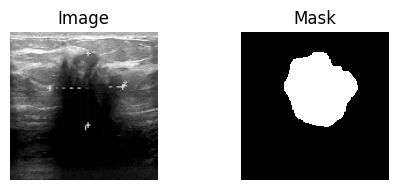

In [7]:
image = X_test[4]
mask = y_test[4]

fig, axes = plt.subplots(1, 2, figsize=(5, 2))
axes[0].imshow(image, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Image')

axes[1].imshow(mask*255, cmap='gray', vmin=0, vmax=1)
axes[1].axis('off')
axes[1].set_title('Mask')

plt.tight_layout()
plt.show()

#### Visualization of testing images

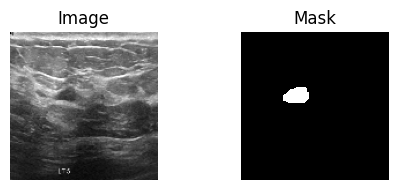

In [8]:
image = X_test[5]
mask = y_test[5]

fig, axes = plt.subplots(1, 2, figsize=(5, 2))
axes[0].imshow(image, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Image')

axes[1].imshow(mask*255, cmap='gray', vmin=0, vmax=1)
axes[1].axis('off')
axes[1].set_title('Mask')

plt.tight_layout()
plt.show()

## Custom metrics and losses

#### Metrics

In [9]:
def dice_score(y_true, y_pred):
    smooth = K.epsilon()
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    score = (2. * intersection + smooth) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smooth)
    return score

def iou(y_true, y_pred):
    smooth = K.epsilon()
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    union = K.sum(y_true_flat) + K.sum(y_pred_flat) - intersection + smooth
    iou = (intersection + smooth) / union
    return iou

def recall(y_true, y_pred):
    smooth = K.epsilon()
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred_pos)
    tp = K.sum(y_true_flat * y_pred_flat)
    fn = K.sum(y_true_flat * (1 - y_pred_flat))
    recall = (tp + smooth) / (tp + fn + smooth)
    return recall

def precision(y_true, y_pred):
    smooth = K.epsilon()
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred_pos)
    tp = K.sum(y_true_flat * y_pred_flat)
    fp = K.sum((1 - y_true_flat) * y_pred_flat)
    precision = (tp + smooth) / (tp + fp + smooth)
    return precision

#### Loss

In [10]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_score(y_true, y_pred)
    return loss

def iou_loss(y_true, y_pred):
    loss = 1 - iou(y_true, y_pred)
    return loss
    
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
    y_true = tf.cast(y_true, tf.float32)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    focal_weight = alpha * tf.pow(1 - pt, gamma)
    loss = tf.reduce_mean(-focal_weight * tf.math.log(pt))
    return loss

def bce_loss(y_true, y_pred):
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred))
    return loss

def combined_loss(y_true, y_pred):
    loss = dice_loss(y_true, y_pred) + bce_loss(y_true, y_pred)
    return loss

# Custom UNet architecture

#### CBAM attention module

In [11]:
def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape
    ## Shared layers
    l1 = keras.layers.Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = keras.layers.Dense(channel, use_bias=False)
    ## Global Average Pooling
    x1 = keras.layers.GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)
    ## Global Max Pooling
    x2 = keras.layers.GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)
    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = keras.layers.Activation("sigmoid")(feats)
    feats = keras.layers.Multiply()([x, feats])
    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)
    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)
    ## Concatenat both the features
    feats = keras.layers.Concatenate()([x1, x2])
    ## Conv layer
    feats = keras.layers.Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = keras.layers.Multiply()([x, feats])

    return feats

def cbam(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x

#### PAM

In [12]:
class pam(tf.keras.layers.Layer):
    def __init__(self, in_dim):
        super(pam, self).__init__()
        self.channel_in = in_dim

        self.query_conv = Conv2D(in_dim // 8, kernel_size=1)
        self.key_conv = Conv2D(in_dim // 8, kernel_size=1)
        self.value_conv = Conv2D(in_dim, kernel_size=1)
        self.gamma = tf.Variable(tf.zeros((1,)), trainable=True)

        self.softmax = Softmax(axis=-1)

    def forward(self, x):
        """
        inputs :
            x : input feature maps (B X H X W X C)
        returns :
            out : attention value + input feature
            attention: B X (HxW) X (HxW)
        """
        m_batchsize, height, width, C = x.shape
        proj_query = tf.transpose(tf.reshape(self.query_conv(x), [m_batchsize, height * width, -1]), perm=[0, 2, 1])
        proj_key = tf.reshape(self.key_conv(x), [m_batchsize, -1, height * width])
        energy = tf.matmul(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = tf.reshape(self.value_conv(x), [m_batchsize, -1, height * width])
        out = tf.matmul(attention, proj_value)
        out = tf.reshape(out, [m_batchsize, height, width, -1])
        out = self.gamma * out + x
        return out

#### PCBAM

In [13]:
def pcbam(x):
    x_c = channel_attention_module(x)
    x_s = spatial_attention_module(x_c)
    x_p = pam(24)(x)
    out = x_s + x_p
    return x_s

#### SWA

In [14]:
class SWA(tf.keras.layers.Layer):
    def __init__(self, in_dim, n_heads=8, window_size=7):
        super(SWA, self).__init__()
        self.in_dim = in_dim
        self.n_heads = n_heads
        self.window_size = window_size

        self.query_conv = Conv2D(in_dim, kernel_size=1)
        self.key_conv = Conv2D(in_dim, kernel_size=1)
        self.value_conv = Conv2D(in_dim, kernel_size=1)
        self.gamma = tf.Variable(tf.zeros((1,)), trainable=True)

        self.softmax = Softmax(axis=-1)

    def forward(self, x):
        """
        inputs:
            x: input feature maps (B X H X W X C)
        returns:
            out: attention value + input feature
        """
        m_batchsize, height, width, C = x.shape
        padded_x = tf.pad(x, [[0, 0], [self.window_size // 2, self.window_size // 2], [self.window_size // 2, self.window_size // 2], [0, 0]], "REFLECT")

        # Reshape queries, keys, and values
        proj_query = tf.transpose(self.query_conv(x), perm=[0, 3, 1, 2])  # (B X C X H X W)
        proj_key = tf.transpose(self.key_conv(padded_x), perm=[0, 3, 1, 2])  # (B X C X H X W)
        proj_value = tf.transpose(self.value_conv(padded_x), perm=[0, 3, 1, 2])  # (B X C X H X W)

        # Reshape window
        window = tf.image.extract_patches(proj_value,
                                          sizes=[1, self.window_size, self.window_size, 1],
                                          strides=[1, 1, 1, 1],
                                          rates=[1, 1, 1, 1],
                                          padding='VALID')

        # Reshape queries, keys, and values for window
        proj_query_window = tf.reshape(proj_query, [m_batchsize, self.n_heads, C // self.n_heads, height * width])
        proj_key_window = tf.reshape(proj_key, [m_batchsize, self.n_heads, C // self.n_heads, (height + self.window_size - 1) * (width + self.window_size - 1)])
        proj_value_window = tf.reshape(window, [m_batchsize, self.n_heads, C // self.n_heads, (height + self.window_size - 1) * (width + self.window_size - 1)])

        # Calculate attention
        energy = tf.matmul(tf.transpose(proj_query_window, perm=[0, 1, 3, 2]), proj_key_window)  # (B X n_heads X HW X HW)
        attention = self.softmax(energy)

        # Apply attention to values
        out_window = tf.matmul(proj_value_window, tf.transpose(attention, perm=[0, 1, 3, 2]))  # (B X n_heads X C/n_heads X HW)

        # Reshape output window
        out_window = tf.reshape(out_window, [m_batchsize, C, height, width])
        out_window = tf.transpose(out_window, perm=[0, 2, 3, 1])

        # Residual connection
        out = self.gamma * out_window + x

        return out

#### Residual Block

In [15]:
def res_block(x, nb_filters, strides):
    initializer = tf.keras.initializers.HeNormal()
    
    res_path = keras.layers.BatchNormalization()(x)
    res_path = keras.layers.Activation(activation='relu')(res_path)
    res_path = keras.layers.Conv2D(filters=nb_filters[0], kernel_size=(3, 3), padding='same', strides=strides[0], kernel_initializer=initializer)(res_path)
    res_path = keras.layers.BatchNormalization()(res_path)
    res_path = keras.layers.Activation(activation='relu')(res_path)
    res_path = keras.layers.Conv2D(filters=nb_filters[1], kernel_size=(3, 3), padding='same', strides=strides[1], kernel_initializer=initializer)(res_path)

    shortcut = keras.layers.Conv2D(nb_filters[1], kernel_size=(1, 1), strides=strides[0], kernel_initializer=initializer)(x)
    shortcut = keras.layers.BatchNormalization()(shortcut)

    res_path = keras.layers.add([shortcut, res_path])
    return res_path

#### Encoder

In [16]:
def encoder(x):
    to_decoder = []
    initializer = tf.keras.initializers.HeNormal()

    main_path = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1), kernel_initializer=initializer)(x)
    main_path = keras.layers.BatchNormalization()(main_path)
    main_path = keras.layers.Activation(activation='relu')(main_path)

    main_path = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1), kernel_initializer=initializer)(main_path)

    shortcut = keras.layers.Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), kernel_initializer=initializer)(x)
    shortcut = keras.layers.BatchNormalization()(shortcut)

    main_path = keras.layers.add([shortcut, main_path])
    main_path = pcbam(main_path)
    to_decoder.append(main_path)

    main_path = res_block(main_path, [128, 128], [(2, 2), (1, 1)])
    main_path = cbam(main_path)
    to_decoder.append(main_path)

    main_path = res_block(main_path, [256, 256], [(2, 2), (1, 1)])
    main_path = pcbam(main_path)
    to_decoder.append(main_path)

    return to_decoder

#### Decoder

In [17]:
def decoder(x, from_encoder):
    x = SWA(in_dim = 512)(x)
    
    x_1 = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    x_1 = keras.layers.UpSampling2D(size=(2, 2))(x_1)
    
    x_2 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    x_2 = keras.layers.UpSampling2D(size=(2, 2))(x_2)
    x_2 = keras.layers.UpSampling2D(size=(2, 2))(x_2)
    
    x_3 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    x_3 = keras.layers.UpSampling2D(size=(2, 2))(x_3)
    x_3 = keras.layers.UpSampling2D(size=(2, 2))(x_3)
    x_3 = keras.layers.UpSampling2D(size=(2, 2))(x_3)
    
    main_path = keras.layers.UpSampling2D(size=(2, 2))(x)
    main_path = keras.layers.concatenate([main_path, from_encoder[2]], axis=3)
    from_encoder[2] = from_encoder[2] + x_1
    main_path = res_block(main_path, [256, 256], [(1, 1), (1, 1)])

    main_path = keras.layers.UpSampling2D(size=(2, 2))(main_path)
    main_path = keras.layers.concatenate([main_path, from_encoder[1]], axis=3)
    from_encoder[1] = from_encoder[1] + x_2
    main_path = res_block(main_path, [128, 128], [(1, 1), (1, 1)])

    main_path = keras.layers.UpSampling2D(size=(2, 2))(main_path)
    main_path = keras.layers.concatenate([main_path, from_encoder[0]], axis=3)
    from_encoder[0] = from_encoder[0] + x_3
    main_path = res_block(main_path, [64, 64], [(1, 1), (1, 1)])

    return main_path

#### Custom UNeT architecture

In [18]:
def build_res_unet(input_shape):
    inputs = keras.layers.Input(shape=input_shape)
    inputs_rgb = tf.keras.layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x))(inputs)

    to_decoder = encoder(inputs_rgb)

    path = res_block(to_decoder[2], [512, 512], [(2, 2), (1, 1)])

    path = decoder(path, from_encoder=to_decoder)

    path = keras.layers.Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(path)

    return keras.models.Model(inputs=inputs, outputs=path)


model = build_res_unet(input_shape=(128, 128, 1))
optimizer = Adam(lr=0.0001)
model.compile(loss=combined_loss, metrics=["accuracy",dice_score,recall,precision,iou], optimizer = optimizer)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['lambda[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                               

# Training

In [19]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/seg.tf',
    monitor='val_dice_score',
    save_best_only=True,
    mode='max',
    verbose=1
    )

history = model.fit(X_train, y_train,
                    epochs = 50,
                    batch_size = 4,
                    validation_data = (X_val,y_val),
                    verbose = 1,
                    callbacks=[model_checkpoint_callback],
                    shuffle = True)

Epoch 1/50
117/117 [==============================] - ETA: 0s - loss: 1.3611 - accuracy: 0.8730 - dice_score: 0.3589 - recall: 0.4197 - precision: 0.3871 - iou: 0.2289
Epoch 1: val_dice_score improved from -inf to 0.19076, saving model to /kaggle/working/seg.tf
117/117 [==============================] - 51s 224ms/step - loss: 1.3611 - accuracy: 0.8730 - dice_score: 0.3589 - recall: 0.4197 - precision: 0.3871 - iou: 0.2289 - val_loss: 1.9330 - val_accuracy: 0.2415 - val_dice_score: 0.1908 - val_recall: 0.9879 - val_precision: 0.1082 - val_iou: 0.1078
Epoch 2/50
116/117 [============================>.] - ETA: 0s - loss: 1.2477 - accuracy: 0.9022 - dice_score: 0.4560 - recall: 0.4870 - precision: 0.5013 - iou: 0.3080
Epoch 2: val_dice_score improved from 0.19076 to 0.35039, saving model to /kaggle/working/seg.tf
117/117 [==============================] - 22s 190ms/step - loss: 1.2474 - accuracy: 0.9020 - dice_score: 0.4569 - recall: 0.4862 - precision: 0.5049 - iou: 0.3087 - val_loss: 1.4

#### Plots of metrices and losses

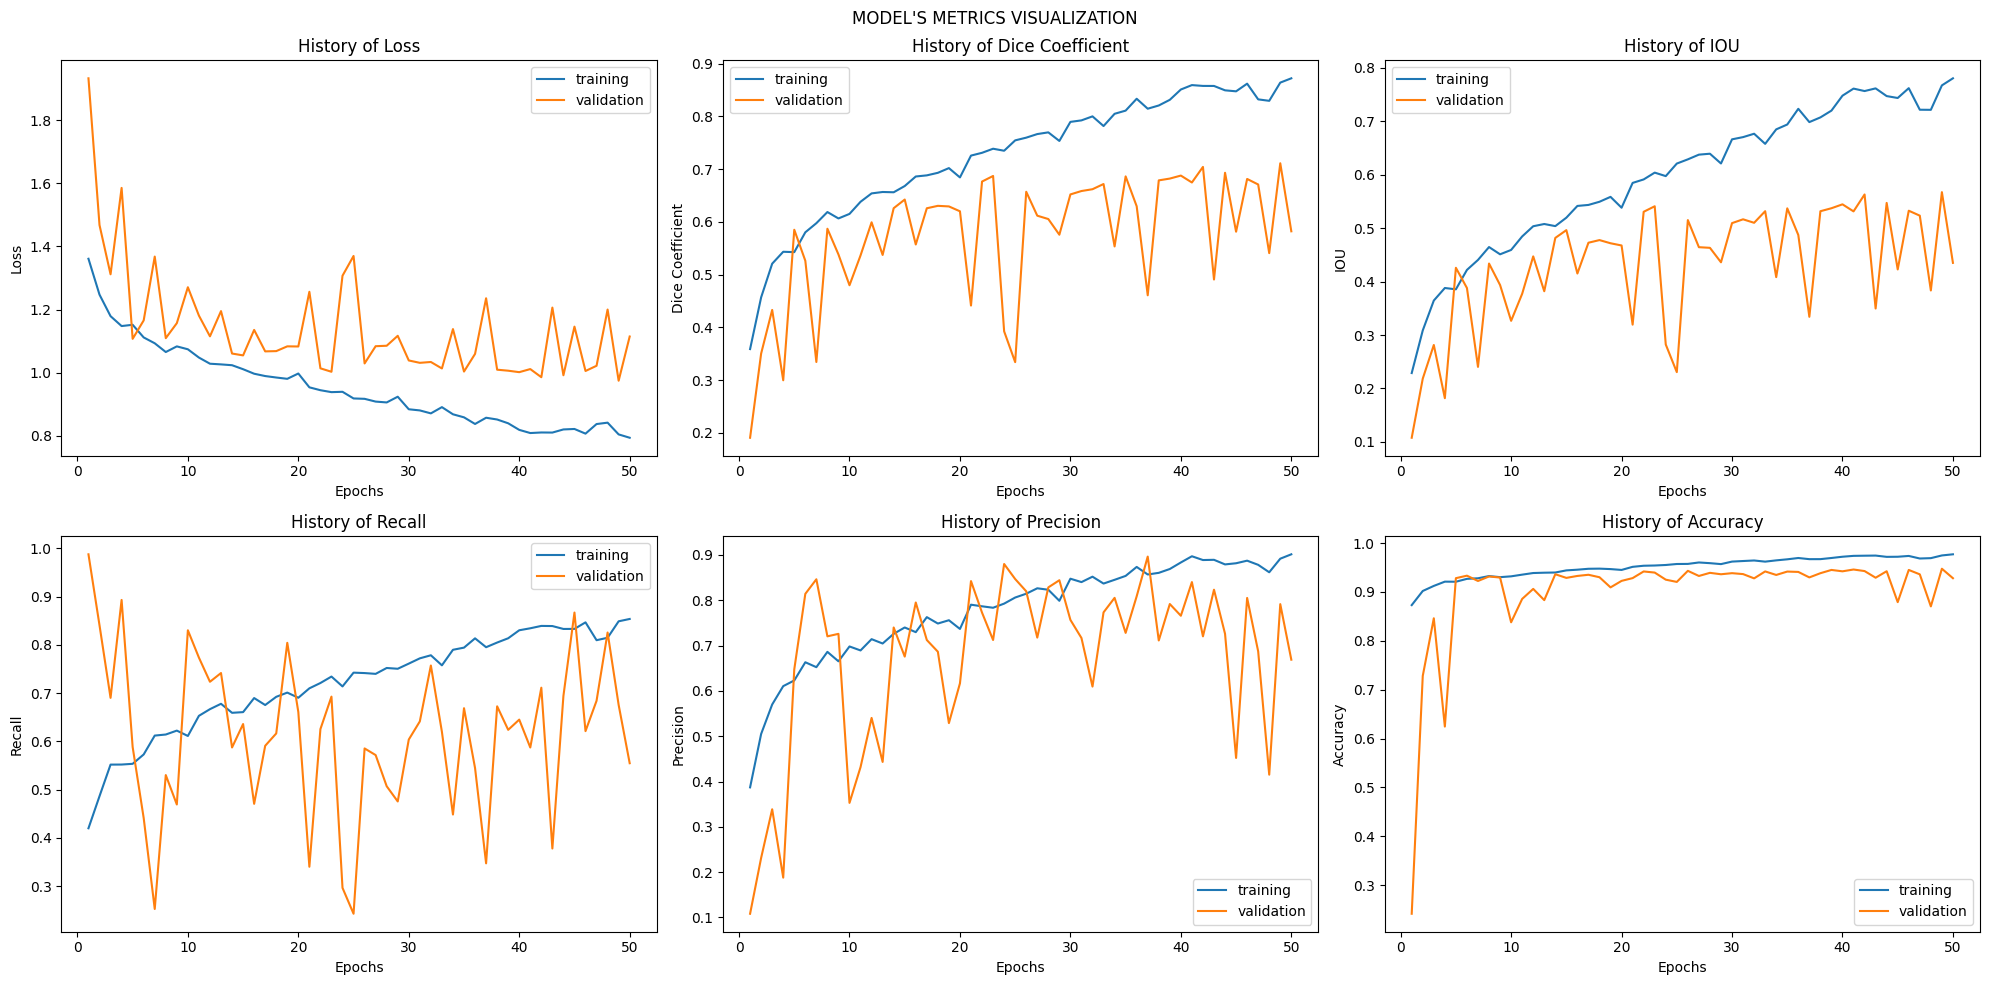

In [20]:
def Train_Val_Plot(loss, val_loss, dice_score, val_dice_score, iou, val_iou, recall, val_recall, precision, val_precision, accuracy, val_accuracy):
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle("MODEL'S METRICS VISUALIZATION")

    # Loss plot
    axs[0, 0].plot(range(1, len(loss) + 1), loss)
    axs[0, 0].plot(range(1, len(val_loss) + 1), val_loss)
    axs[0, 0].set_title('History of Loss')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend(['training', 'validation'])

    # Dice Coefficient plot
    axs[0, 1].plot(range(1, len(dice_score) + 1), dice_score)
    axs[0, 1].plot(range(1, len(val_dice_score) + 1), val_dice_score)
    axs[0, 1].set_title('History of Dice Coefficient')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Dice Coefficient')
    axs[0, 1].legend(['training', 'validation'])

    # Mean IOU plot
    axs[0, 2].plot(range(1, len(iou) + 1), iou)
    axs[0, 2].plot(range(1, len(val_iou) + 1), val_iou)
    axs[0, 2].set_title('History of IOU')
    axs[0, 2].set_xlabel('Epochs')
    axs[0, 2].set_ylabel('IOU')
    axs[0, 2].legend(['training', 'validation'])

    # Recall plot
    axs[1, 0].plot(range(1, len(recall) + 1), recall)
    axs[1, 0].plot(range(1, len(val_recall) + 1), val_recall)
    axs[1, 0].set_title('History of Recall')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Recall')
    axs[1, 0].legend(['training', 'validation'])

    # Precision plot
    axs[1, 1].plot(range(1, len(precision) + 1), precision)
    axs[1, 1].plot(range(1, len(val_precision) + 1), val_precision)
    axs[1, 1].set_title('History of Precision')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Precision')
    axs[1, 1].legend(['training', 'validation'])

    # Accuracy plot
    axs[1, 2].plot(range(1, len(accuracy) + 1), accuracy)
    axs[1, 2].plot(range(1, len(val_accuracy) + 1), val_accuracy)
    axs[1, 2].set_title('History of Accuracy')
    axs[1, 2].set_xlabel('Epochs')
    axs[1, 2].set_ylabel('Accuracy')
    axs[1, 2].legend(['training', 'validation'])

    plt.tight_layout()
    plt.show()

Train_Val_Plot(
    history.history['loss'], history.history['val_loss'],
    history.history['dice_score'], history.history['val_dice_score'],
    history.history['iou'], history.history['val_iou'],
    history.history['recall'], history.history['val_recall'],
    history.history['precision'], history.history['val_precision'],
    history.history['accuracy'], history.history['val_accuracy']
)

# Testing

#### Testing results

In [21]:
model = tf.keras.models.load_model("/kaggle/working/seg.tf", custom_objects={"dice_score":dice_score,"recall":recall,"precision":precision,"iou":iou,"combined_loss":combined_loss})
loss, acc, dice, rec, pre, iou = model.evaluate(X_test, y_test, verbose=0)

/opt/conda/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [33]:
print("Loss:", loss)
print("Accuracy:", acc)
print("Dice:", dice)
print("Precision:", pre)
print("Recall:", rec)
print("IOU:", iou)

Loss: 0.9413414633274079
Accuracy: 0.9643132879137992
Dice: 0.7422957241535186
Precision: 0.7362392783164977
Recall: 0.749004478752613
IOU: 0.6584549403190613


#### Segmentation output

In [23]:
modeller = Model(inputs=model.input, outputs=[model.get_layer(name="concatenate_5").output,model.get_layer(name="concatenate_4").output,model.get_layer(name="swa").output])

1/1 [==============================] - 1s 520ms/step


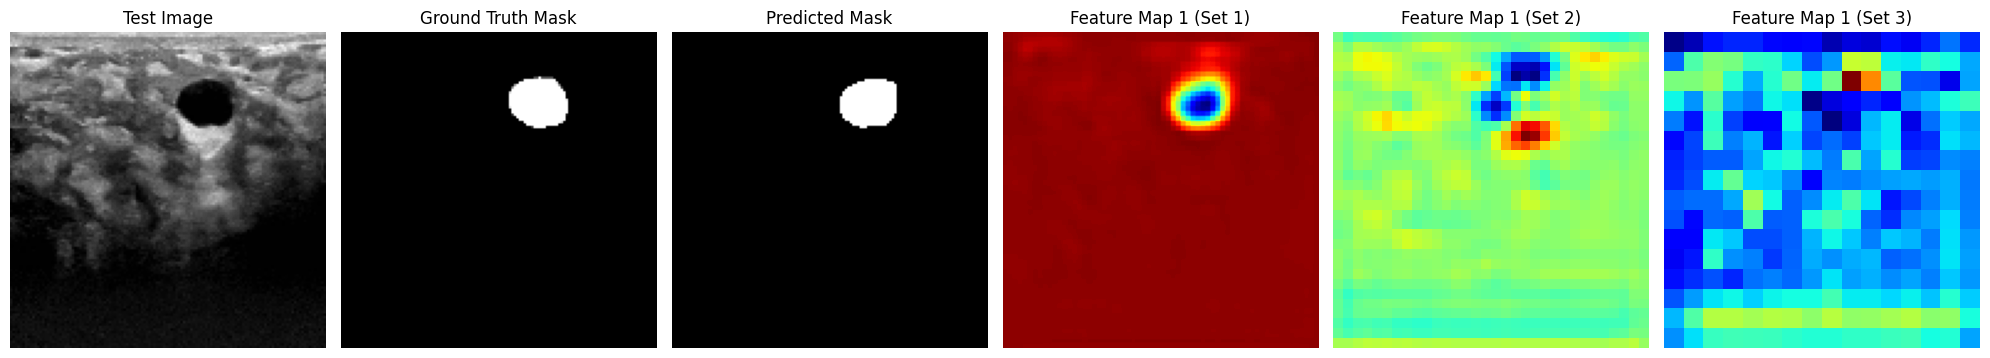

1/1 [==============================] - 0s 20ms/step


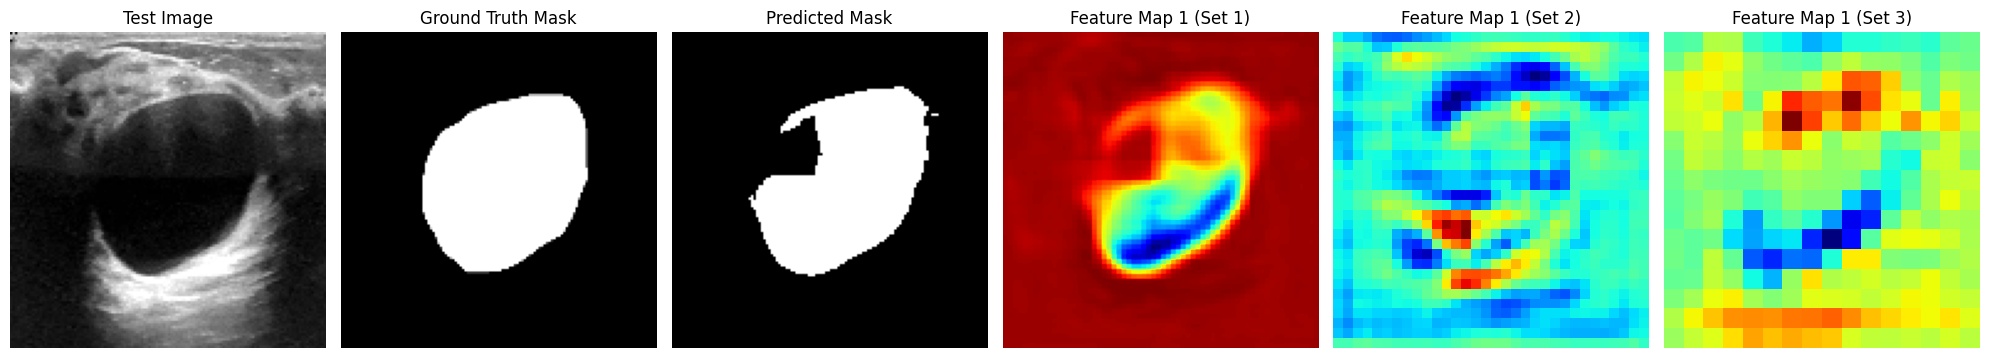

1/1 [==============================] - 0s 21ms/step


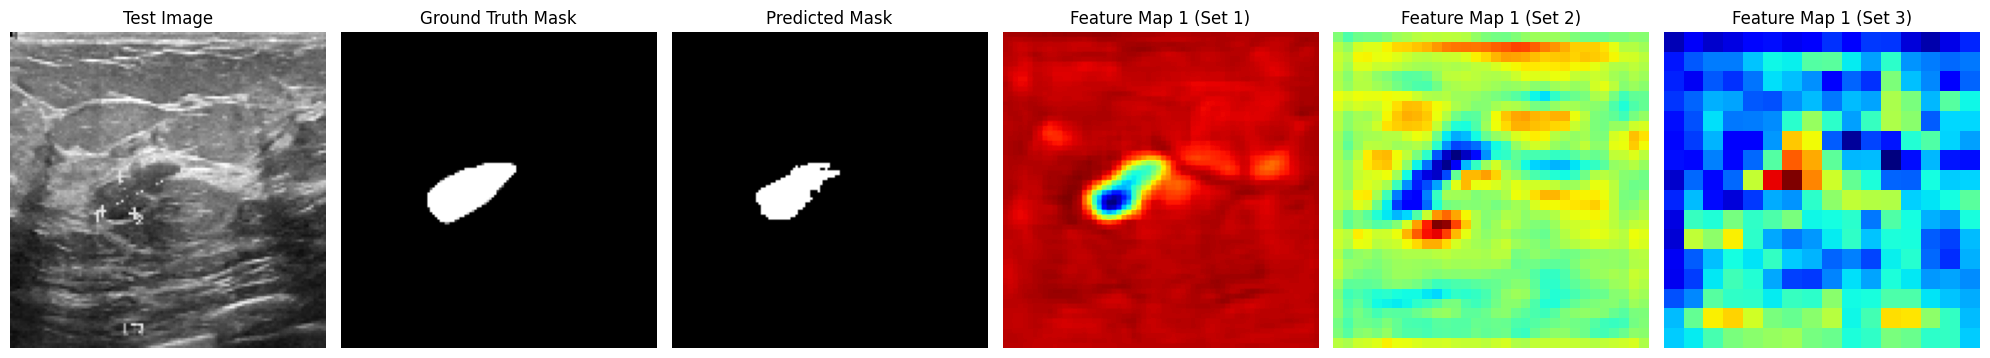

1/1 [==============================] - 0s 21ms/step


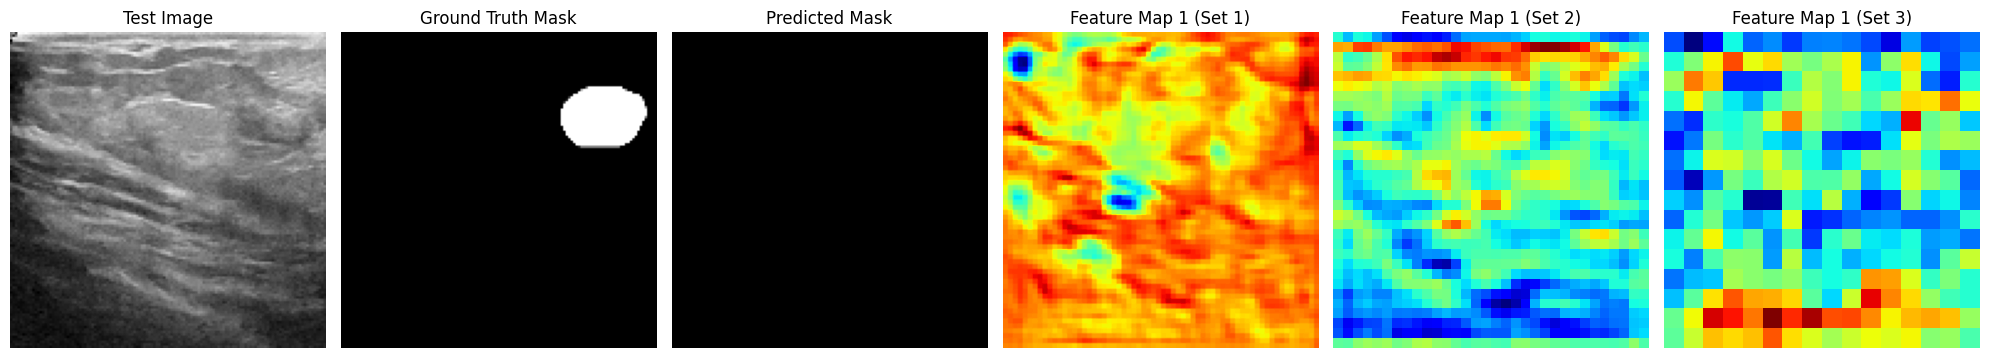

1/1 [==============================] - 0s 20ms/step


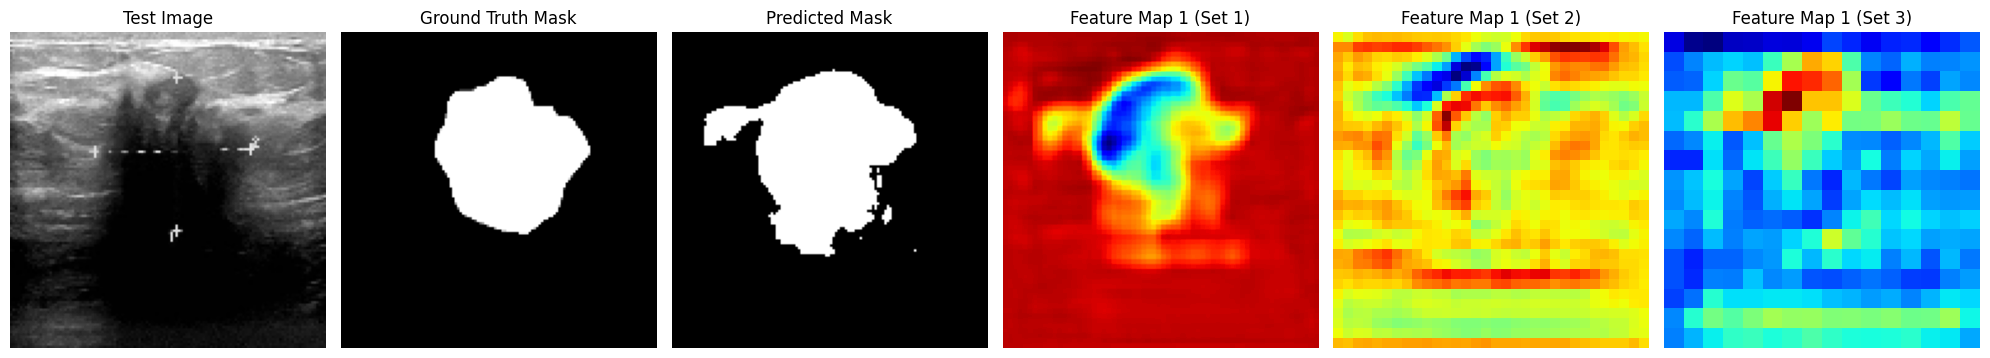

1/1 [==============================] - 0s 21ms/step


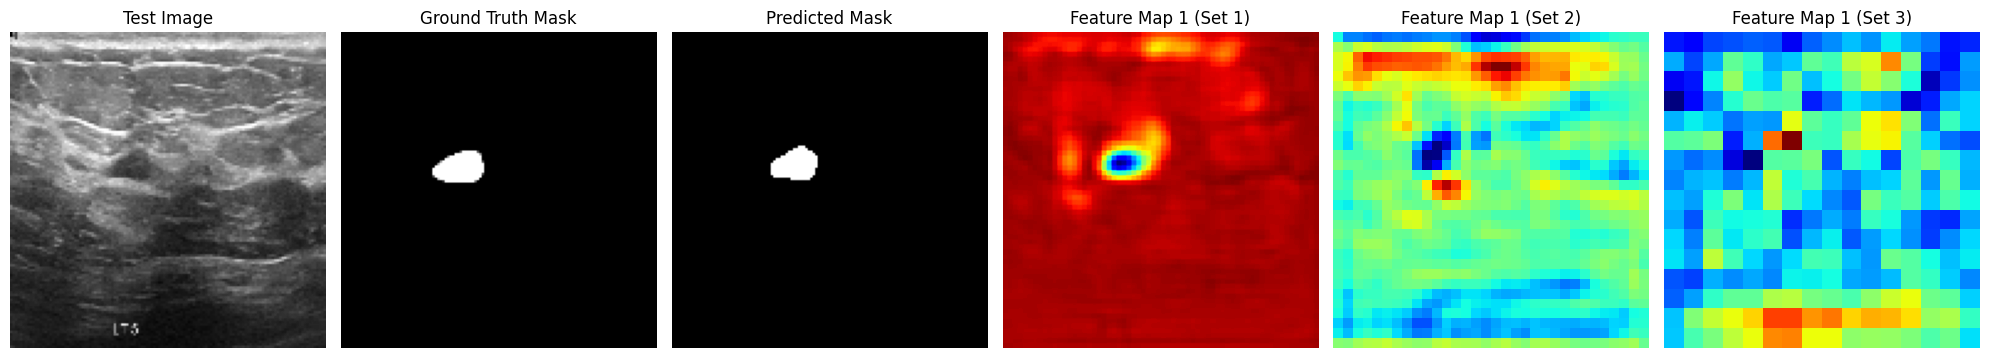

1/1 [==============================] - 0s 22ms/step


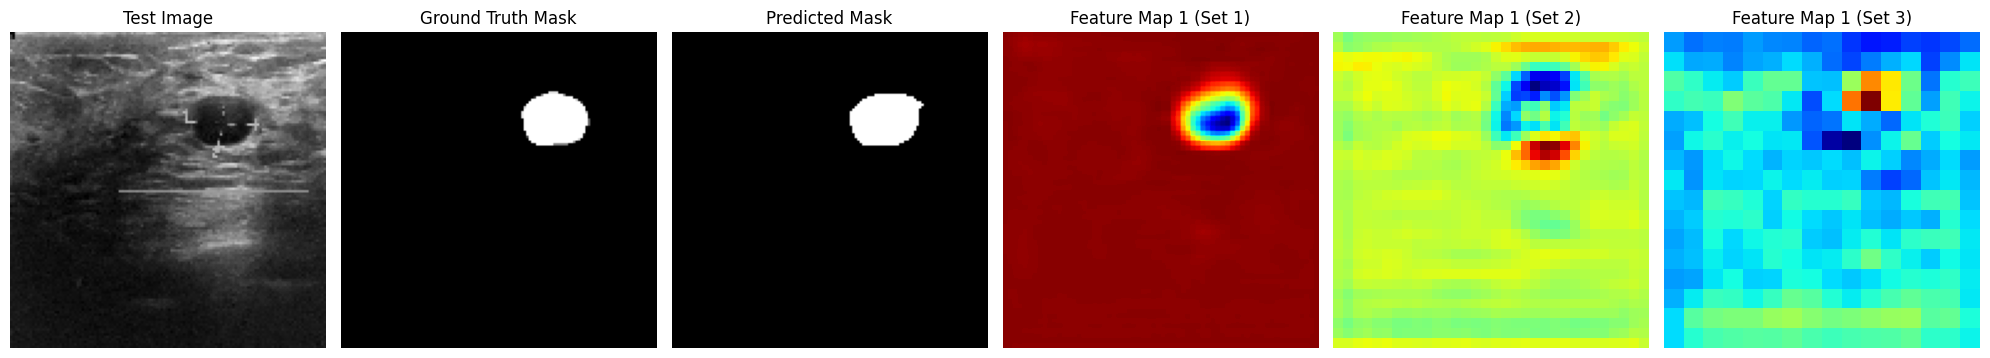

1/1 [==============================] - 0s 21ms/step


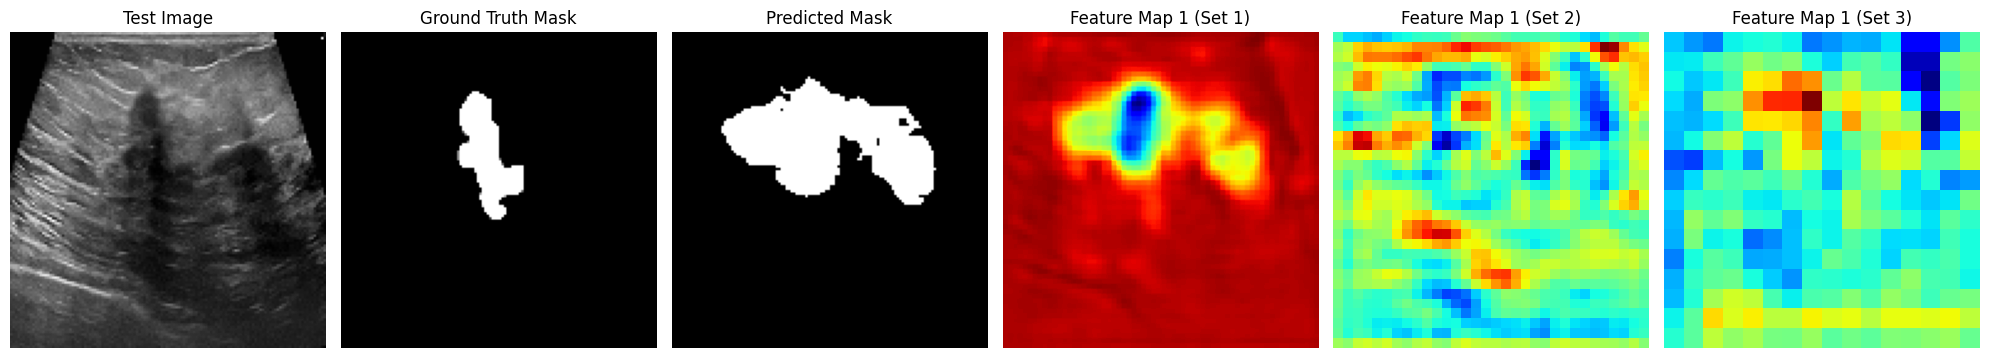

1/1 [==============================] - 0s 22ms/step


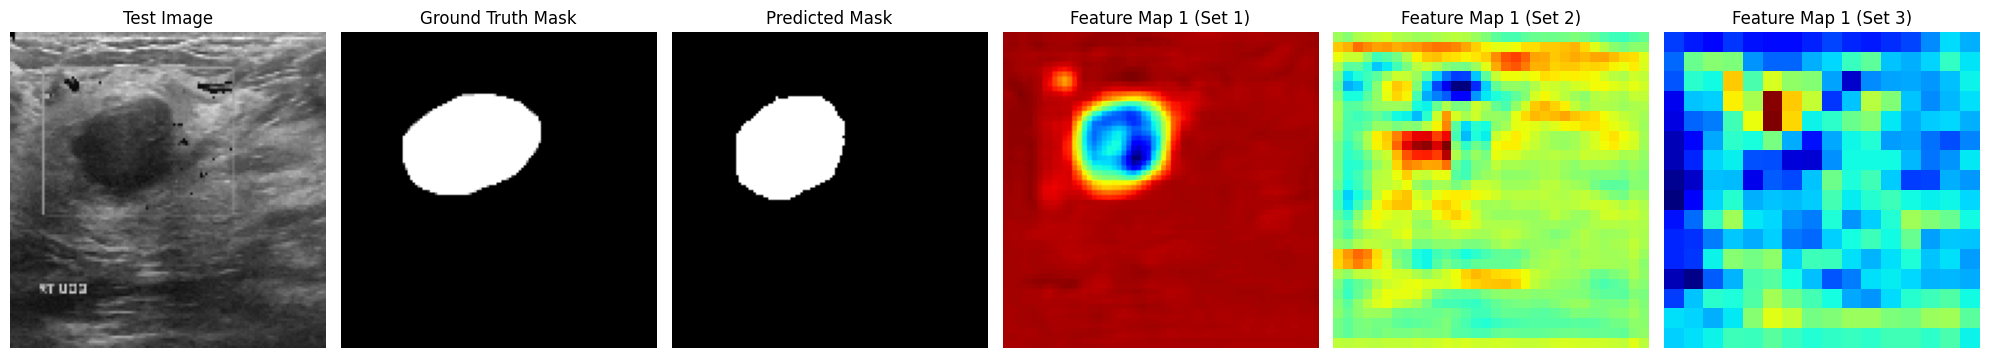

1/1 [==============================] - 0s 22ms/step


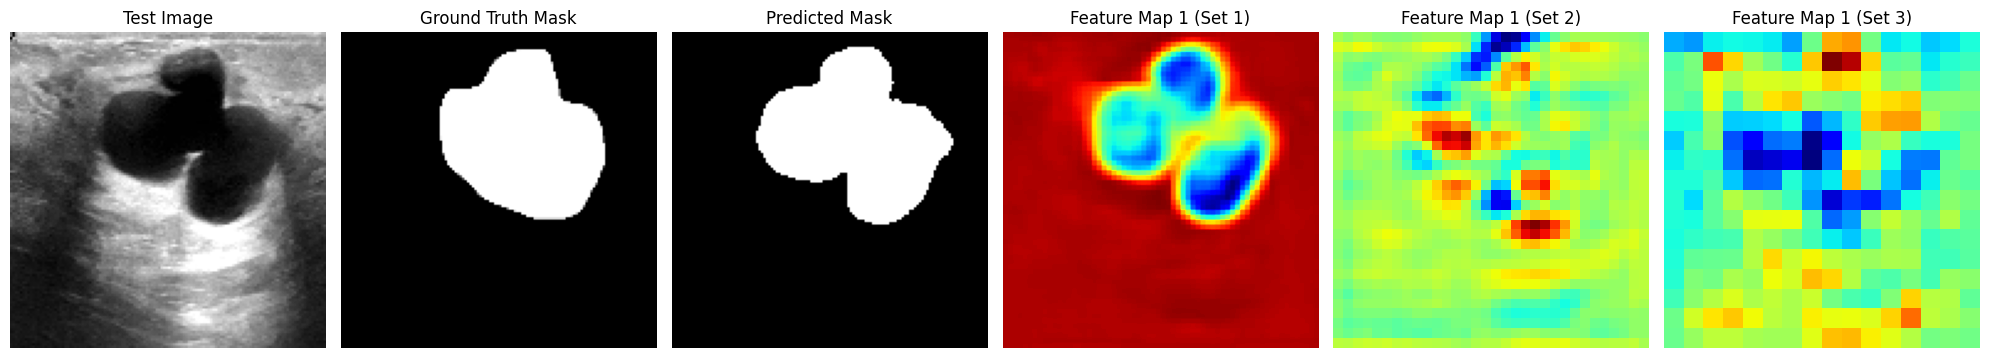

1/1 [==============================] - 0s 24ms/step


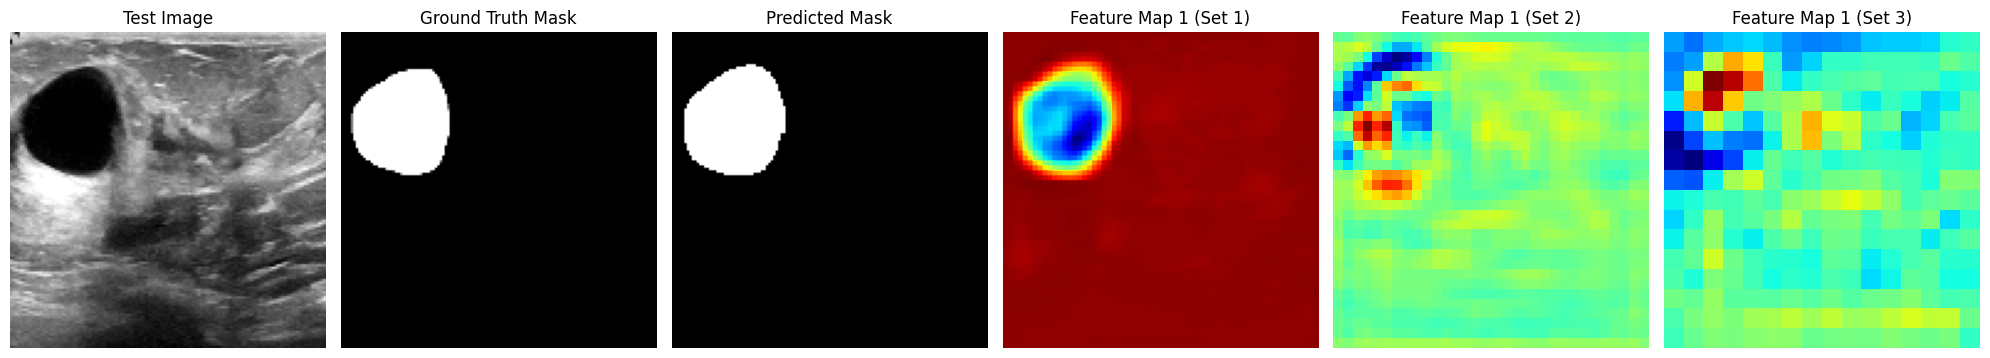

1/1 [==============================] - 0s 22ms/step


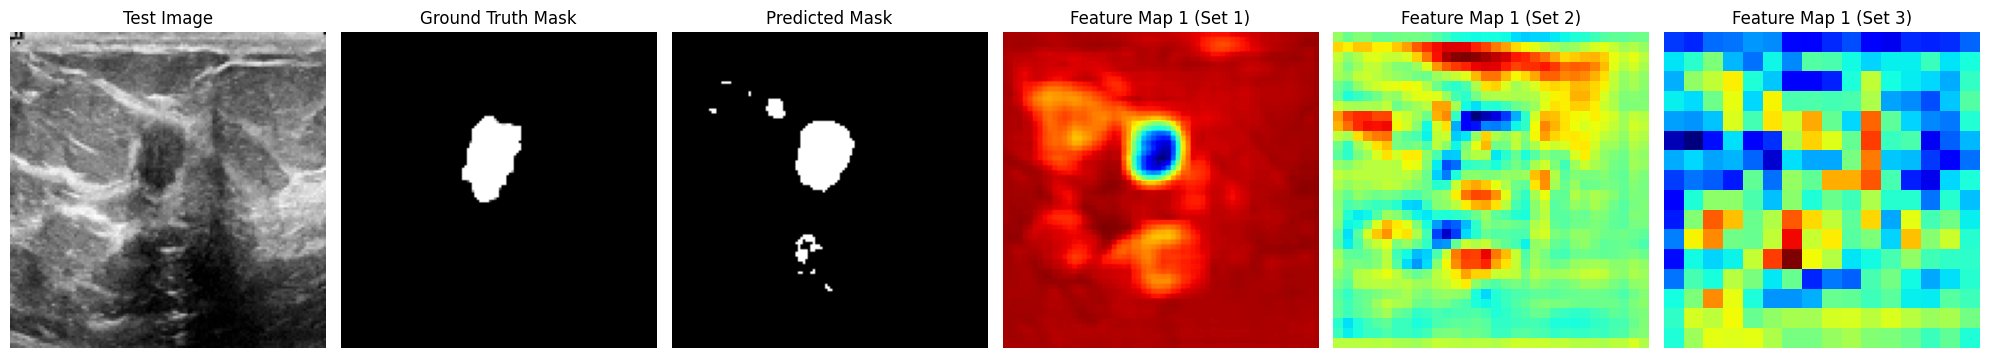

1/1 [==============================] - 0s 22ms/step


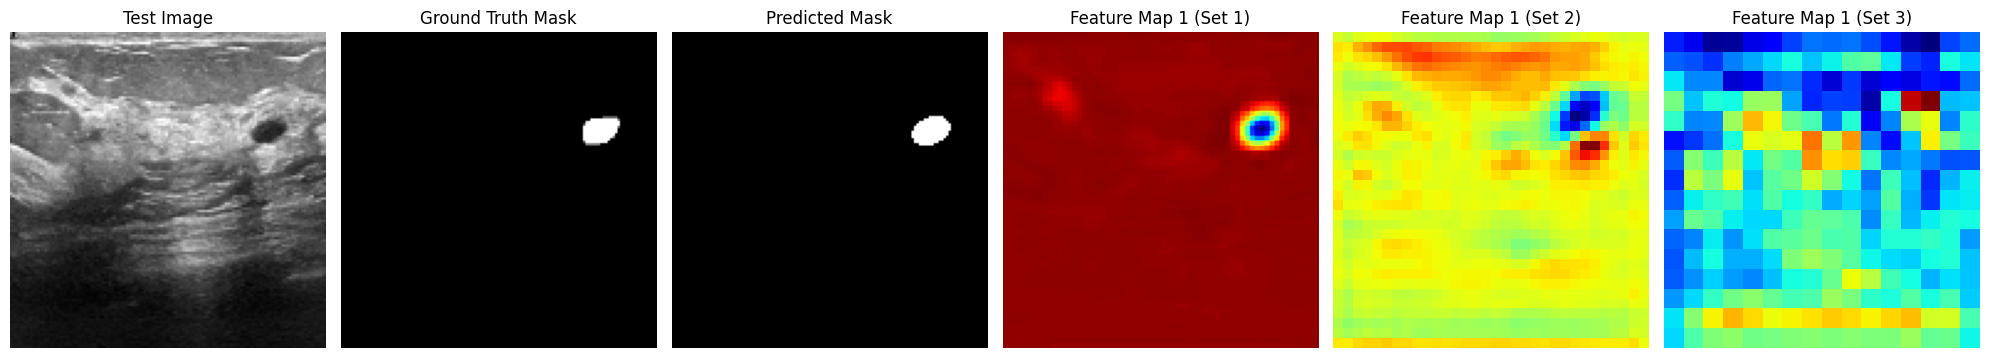

1/1 [==============================] - 0s 20ms/step


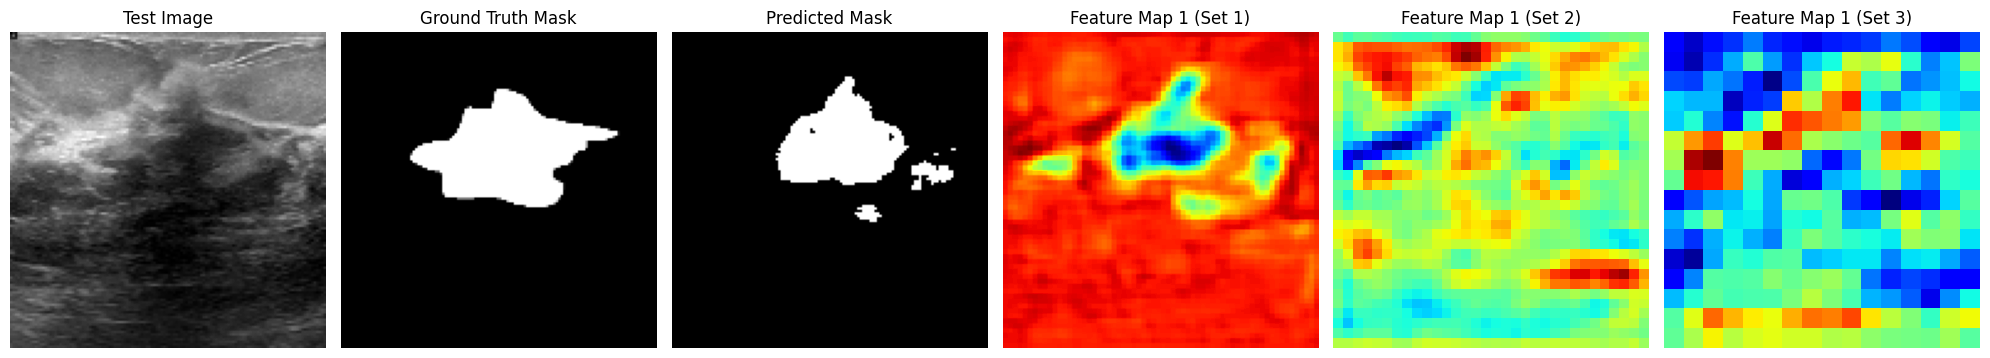

1/1 [==============================] - 0s 21ms/step


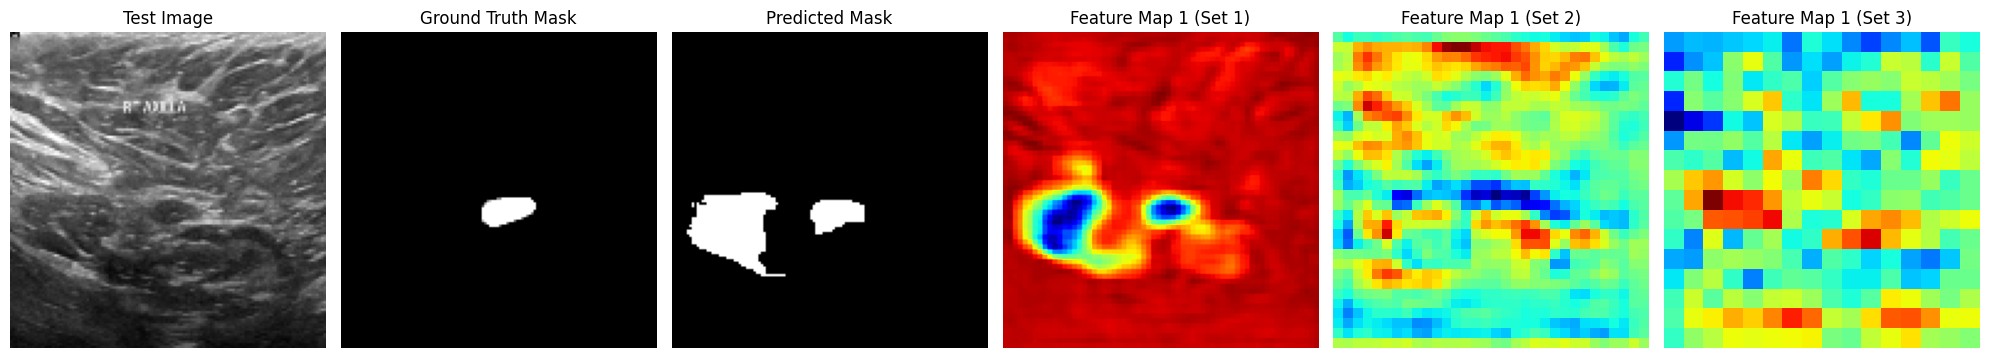

In [24]:
for z in range(15):
    # Load one image and corresponding mask from the test dataset
    test_image = X_test[z]  # Replace X_test with your actual test dataset
    test_mask = y_test[z]  # Replace y_test with your actual test masks

    # Reshape the image to match the input shape of the model
    test_image = np.reshape(test_image, (1,) + test_image.shape)

    # Predict the segmentation mask for the test image
    predicted_mask = model.predict(test_image)[0]
    feature_map1, feature_map2, feature_map3 = modeller.predict(test_image)

    # Convert the predicted mask values to binary (0 or 1)
    predicted_mask_binary = np.where(predicted_mask > 0.5, 1, 0) * 255

    # Create subplots
    fig, axes = plt.subplots(1, len(feature_map1) + 5, figsize=(20, 4))

    # Plot the test image
    axes[0].imshow(test_image[0], cmap='gray')
    axes[0].set_title('Test Image')
    axes[0].axis('off')

    # Plot the ground truth mask
    axes[1].imshow(test_mask, cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    # Plot the predicted mask
    axes[2].imshow(predicted_mask_binary, cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    # Plot the feature maps (Set 1)
    for i, fmap in enumerate(feature_map1):
        axes[i + 3].imshow(fmap[:, :, 0], cmap='jet')
        axes[i + 3].set_title(f'Feature Map {i + 1} (Set 1)')
        axes[i + 3].axis('off')

    # Plot the feature maps (Set 2)
    for i, fmap in enumerate(feature_map2):
        axes[i + 3 + len(feature_map1)].imshow(fmap[:, :, 0], cmap='jet')
        axes[i + 3 + len(feature_map1)].set_title(f'Feature Map {i + 1} (Set 2)')
        axes[i + 3 + len(feature_map1)].axis('off')

    # Plot the feature maps (Set 3)
    for i, fmap in enumerate(feature_map3):
        axes[i + 3 + len(feature_map1) + len(feature_map2)].imshow(fmap[:, :, 0], cmap='jet')
        axes[i + 3 + len(feature_map1) + len(feature_map2)].set_title(f'Feature Map {i + 1} (Set 3)')
        axes[i + 3 + len(feature_map1) + len(feature_map2)].axis('off')

    plt.tight_layout()
    plt.show()